In [1]:
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import classification_report
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Read the data

In [2]:
todds_file = "../data/OpenBCI-RAW-2017-08-28_11-10-26_entrainment.txt"
adrians_file = "../data/OpenBCI-RAW-2017-08-10_15-06-15.txt"
zeus_file = "../data/OpenBCI-RAW-2017-08-10_15-19-42.txt"
data = {"todd":{"filename":todds_file}, "adrian":{"filename":adrians_file},"zeus":{"filename":zeus_file}}

In [3]:
def read_eeg_data(filename, channel_count=16, accel=True, final_col="Timestamp", set_time_index=True):
    """Reads eeg data with options for number of channels and different OpenBCI data formats"""
    data_cols = ["Channel_"+str(i) for i in range(channel_count)] 
    if accel:
        data_cols = data_cols + ["Accel_"+str(i) for i in range(3)]
    columns = ["SampleIndex"] + data_cols + [final_col]
    df = pd.read_csv(filename,names=columns,skiprows=6)
    # drop first second and last second
    df = df.iloc[256:-256]
    if set_time_index:
        df.set_index(keys='Timestamp', inplace=True)
    return df

In [4]:
data = read_eeg_data(todds_file)

In [5]:
sampling_rate = 256 #hz

In [6]:
def view_segment(df, channel_count=16, start_index=0, stop_index=-1, sampling_rate=sampling_rate):
    """View the raw EEG signals"""
    duration=int(len(df.iloc[start_index:stop_index])/sampling_rate)
    print("{} seconds of recording".format(duration))
    df.iloc[start_index:stop_index][["Channel_"+str(i) for i in range(channel_count)]].plot(figsize=(16,9))
    plt.legend(loc=6)
    plt.xlabel('Timestamp',fontsize=22)
    plt.ylabel('Relative microvolts (uV)',fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=22)
    plt.show()

83 seconds of recording


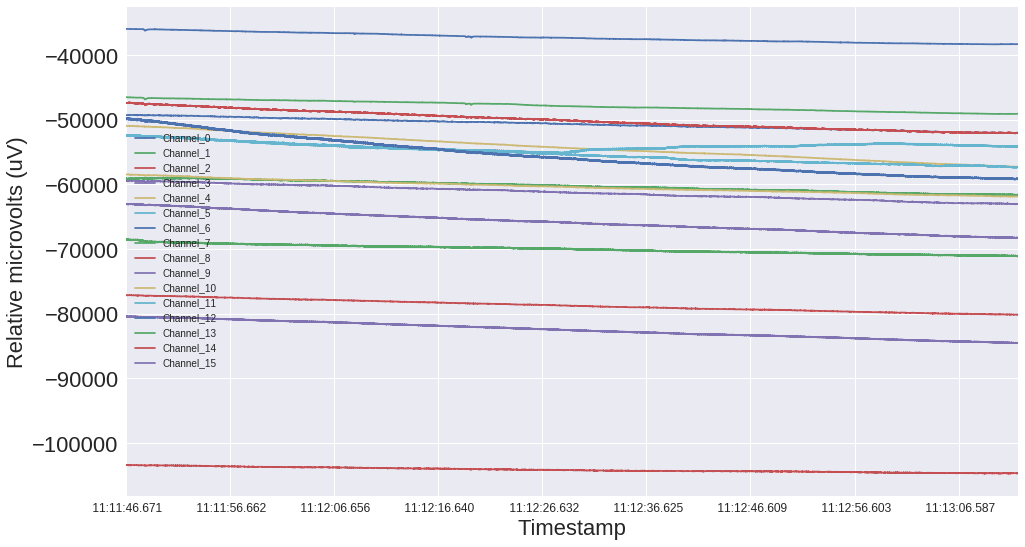

In [7]:
view_segment(data, channel_count=16, start_index=10000, stop_index=-3000)

In [8]:
def envelope_plot(df, channel_count=16, start_index=1000, duration=256):
    """Zooms in on a shorter segment, such as one second, and plots the results"""
    f, axarr = plt.subplots(channel_count, sharex=True)
    for i in range(channel_count):
        df.iloc[start_index:start_index+sampling_rate][["Channel_" + str(i)]].plot(ax=axarr[i],figsize=(16,9))
    plt.show()

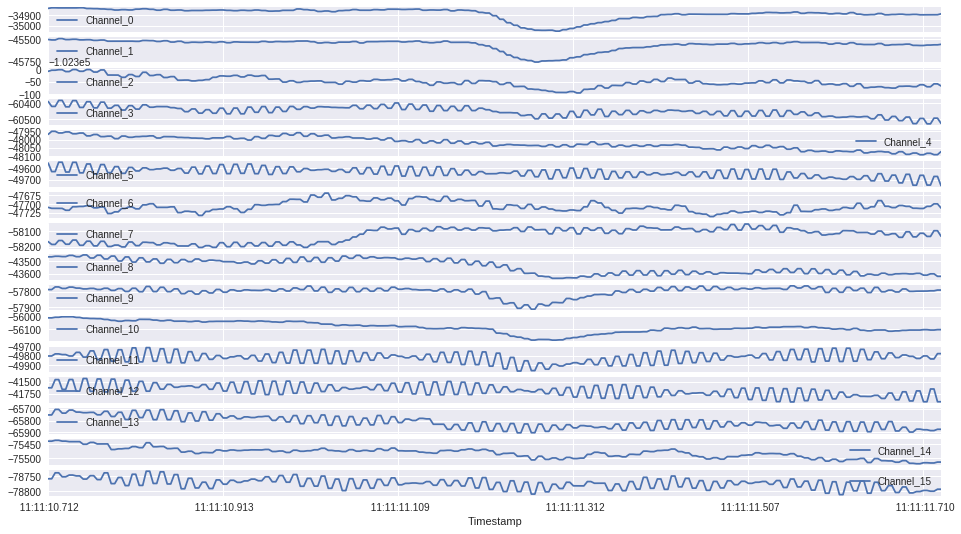

In [9]:
envelope_plot(data)

In [10]:
def bandpass_filter(df, channel=8, highpass_freq=1., lowpass_freq=40., notch_freqs=[60.,120.], sampling_rate=sampling_rate):
    """Filters out specified frequencies +/- 3 hz, mostly to filter out interference from the utility power
    transmission frequency"""
    # https://github.com/chipaudette/EEGHacker/blob/master/Data/2014-10-03%20V3%20Alpha/exploreData.py
    # filter the data to remove DC
    signal_data = df["Channel_{}".format(channel)]
    print("highpass filtering at: " + str(highpass_freq) + " Hz")
    b, a = signal.butter(2, highpass_freq/(sampling_rate / 2.0), 'highpass')  # define the filter
    clean_signal = signal.lfilter(b, a, signal_data, 0) # apply along the zeroeth dimension
    
    print("lowpass filtering at: " + str(lowpass_freq) + " Hz")
    b, a = signal.butter(2, lowpass_freq/(sampling_rate / 2.0), 'lowpass')  # define the filter
    clean_signal = signal.lfilter(b, a, signal_data, 0) # apply along the zeroeth dimension

    # notch filter the data to remove 60 Hz and 120 Hz interference
    for freq_Hz in notch_freqs:  # loop over each center freq
        bp_stop_Hz = freq_Hz + 3.0*np.array([-1, 1])  # set the stop band
        print("notch filtering: " + str(bp_stop_Hz[0]) + "-" + str(bp_stop_Hz[1]) + " Hz")
        b, a = signal.butter(3, bp_stop_Hz/(sampling_rate / 2.0), 'bandstop')  # create the filter
        clean_signal = signal.lfilter(b, a, clean_signal, 0)  # apply along the zeroeth dimension
    
    return clean_signal

In [11]:
def spectrogram(signal, NFFT=1024, overlap=.1, sampling_rate=sampling_rate, min_freq=0, max_freq=40, plot=False):
    """https://matplotlib.org/examples/pylab_examples/specgram_demo.html
    Pxx is the segments x freqs array of instantaneous power, freqs is
    the frequency vector, bins are the centers of the time bins in which
    the power is computed, and im is the matplotlib.image.AxesImage
    instance"""
    
    NFFT = int(NFFT) # length of the fft
    overlap = NFFT - int(overlap * NFFT)  

    fig = plt.figure(figsize=(30, 9))

    Pxx, freqs, bins, im = plt.specgram(signal,NFFT=NFFT,\
                                        Fs=sampling_rate, noverlap=overlap, \
                                        cmap=plt.get_cmap('viridis'))

    Pxx_perbin = Pxx * sampling_rate / float(NFFT)  #convert to "per bin"
    
    if plot:
        plt.pcolor(bins, freqs, 10*np.log10(Pxx_perbin), cmap=plt.get_cmap('jet'))  # dB re: 1 uV
        plt.clim(-20, 10)
        plt.xlim(bins[0], bins[-1])
        plt.ylim(min_freq,max_freq)
        plt.xlabel('Time (sec)',fontsize=22)
        plt.ylabel('Frequency (Hz)',fontsize=22)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.show()
    
    return Pxx_perbin, freqs, bins

6
highpass filtering at: 1.0 Hz
lowpass filtering at: 40.0 Hz
notch filtering: 57.0-63.0 Hz
notch filtering: 117.0-123.0 Hz


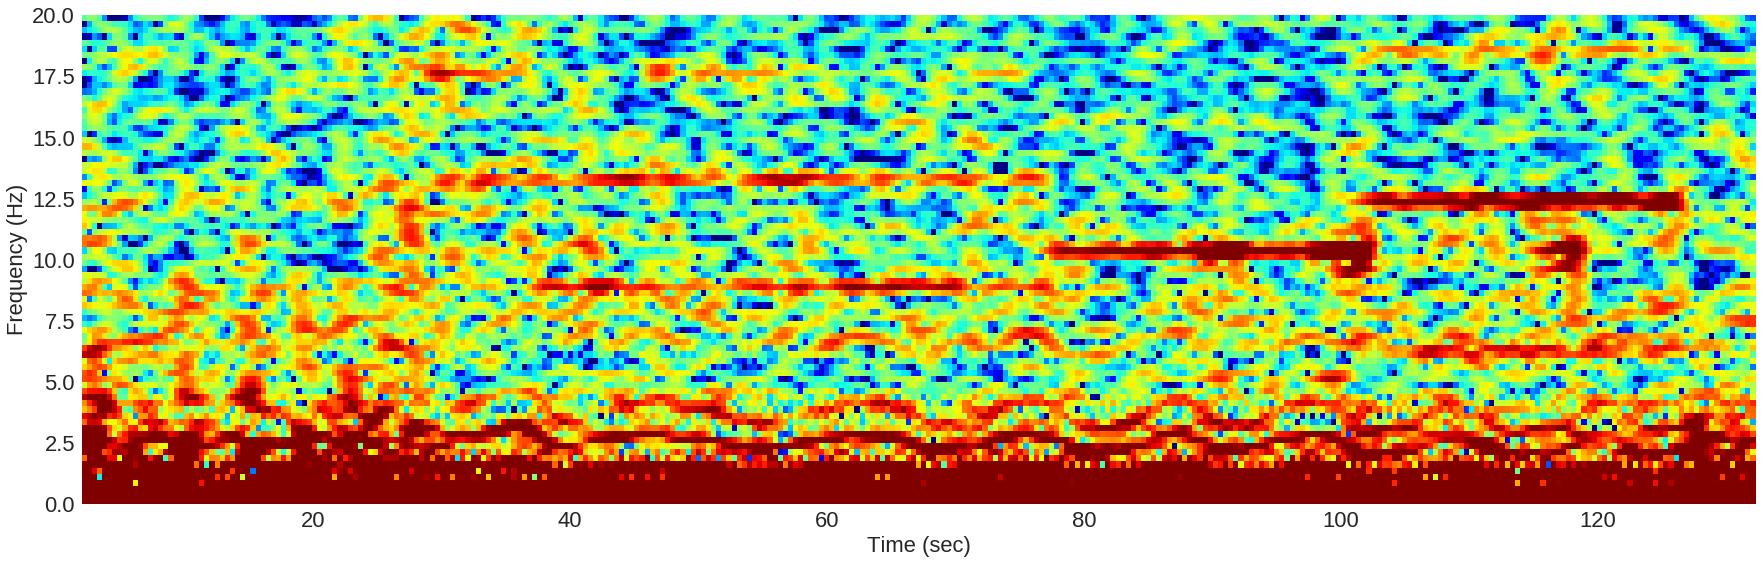

In [12]:
start=120*256
stop=256*175

for chan in [6]:    
    print(chan)
    raw_signal = bandpass_filter(data,channel=chan)#[start:stop]
    power, freqs, time_steps = spectrogram(raw_signal, min_freq=0,max_freq=20, plot=True)

### Try out scipy's stft module

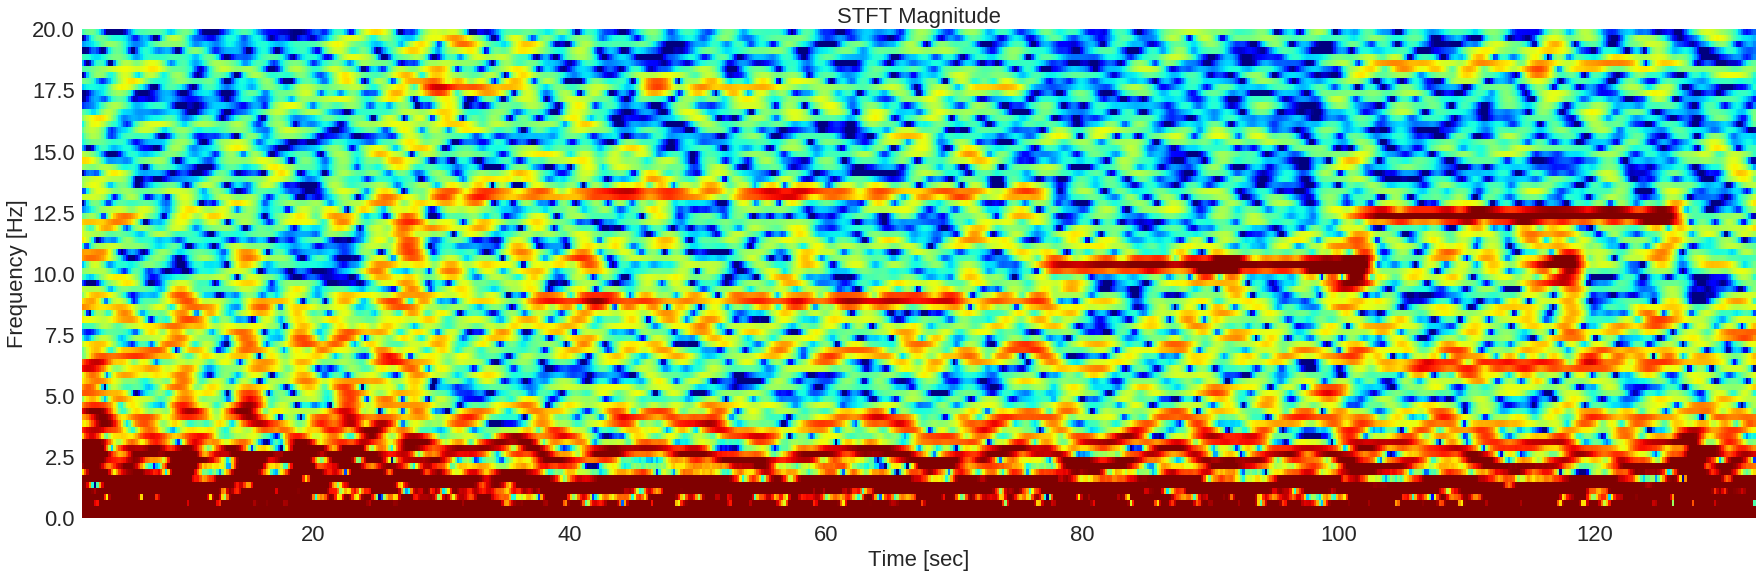

In [13]:
nperseg=1024
noverlap=int(nperseg/1.05)
nfft=nperseg
plt.figure(figsize=(30,9))
# boundary=None got rid of the strips at the start and the end
# zero padding (nfft) interpolates and makes the spectrogram look smoother
# high noverlap gives you smooth temporal resolution
f, t, Zxx = signal.stft(raw_signal, sampling_rate, nperseg=nperseg, noverlap=noverlap, nfft=nfft, boundary=None)
plt.pcolormesh(t, f, 10*np.log10(np.abs(Zxx)),cmap=plt.get_cmap('jet'))
plt.title('STFT Magnitude', fontsize=22)
plt.ylabel('Frequency [Hz]', fontsize=22)
plt.xlabel('Time [sec]', fontsize=22)
plt.clim(-10, 5)
plt.ylim(0,20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [14]:
def freq_filter(t, freqs, power, min_freq=10.0, max_freq=10.5, plot=True, threshold=3, vertical_plots=None, height=None):
    """Allows you to filter down to a frequency band and measure the mean signal strength. 
    Optionally plot results."""
    condition = (freqs <= max_freq) & (freqs >= min_freq)
    indices = np.where(condition)
    power = np.abs(power)
    filtered_signal = np.mean(power[indices], axis=0)
    signal_length = len(filtered_signal)
    threshold_line = signal_length*[threshold]
    if plot:
        plt.figure(figsize=(16,9))
        plt.title('Frequency Range: {}-{}hz'.format(min_freq, max_freq), fontsize=22)
        plt.ylabel('uVrms', fontsize=22)
        plt.xlabel('Time [sec]', fontsize=22)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.plot(t, filtered_signal)
        plt.plot(t, threshold_line)
        if vertical_plots:
            for val in vertical_plots:
                plt.plot([val]*height, range(height))
        plt.show()
    return filtered_signal

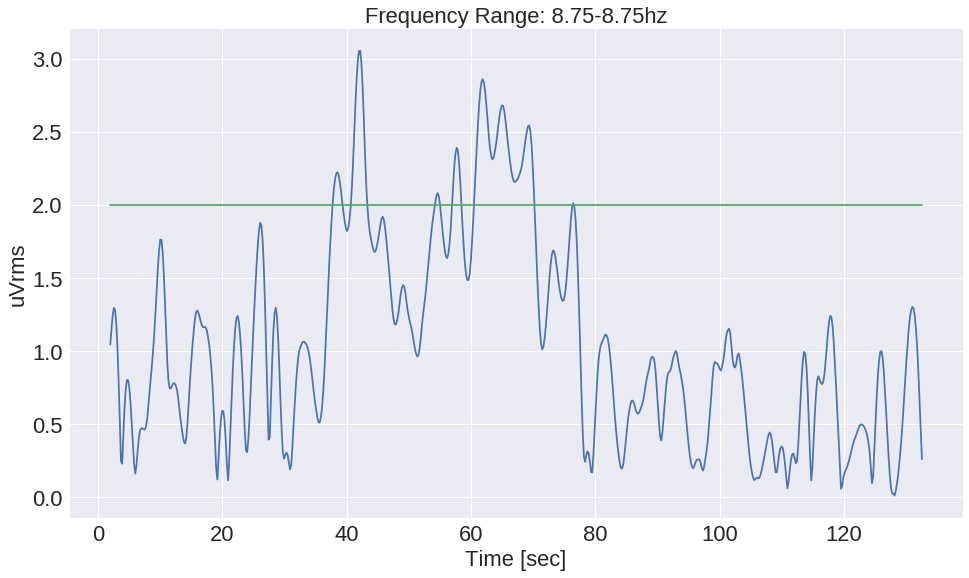

In [15]:
alpha_9 = freq_filter(t, f, Zxx, min_freq=8.75, max_freq=8.75, threshold=2)

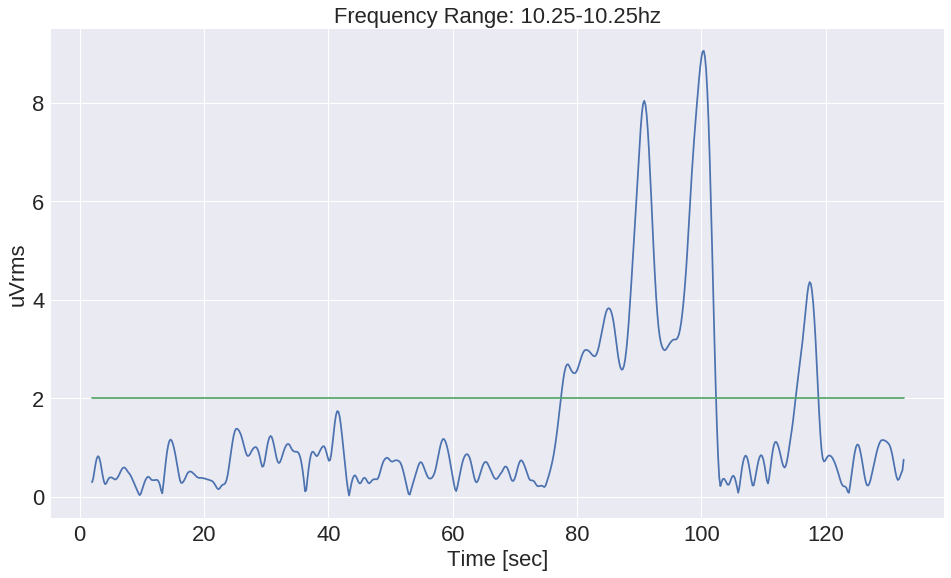

In [16]:
alpha_10 = freq_filter(t, f, Zxx, min_freq=10.25, max_freq=10.25, threshold=2)

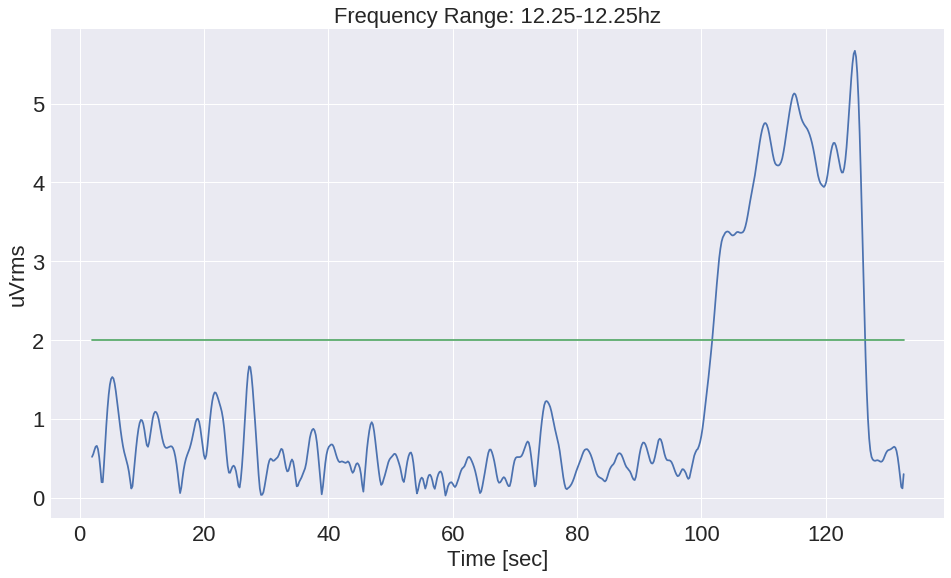

In [17]:
alpha_12 = freq_filter(t, f, Zxx, min_freq=12.25, max_freq=12.25, threshold=2)

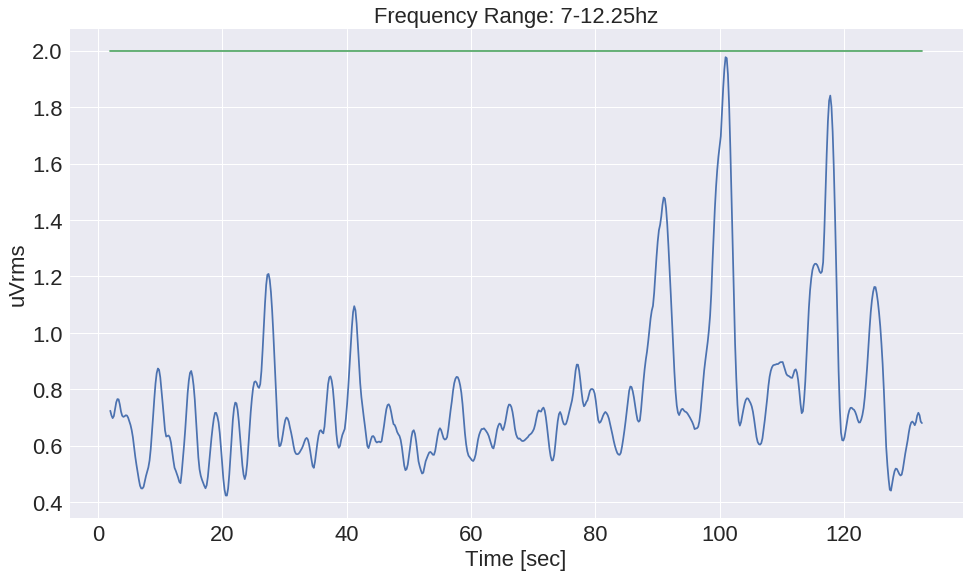

In [18]:
alpha_rando = freq_filter(t, f, Zxx, min_freq=7, max_freq=12.25, threshold=2)

### Yet another way to calculate the STFT
- I realized that in order calculate the FFT in stream mode, this is the way to go

In [19]:
# https://kevinsprojects.wordpress.com/2014/12/13/short-time-fourier-transform-using-python-and-numpy/
fft_size = 1024
overlap_fac = 0.95
hop_size = np.int32(np.floor(fft_size * (1-overlap_fac)))
pad_end_size = fft_size          # the last segment can overlap the end of the data array by no more than one window size
total_segments = np.int32(np.ceil(len(raw_signal) / np.float32(hop_size)))
t_max = len(raw_signal) / np.float32(sampling_rate)

In [20]:
time_steps = int(np.ceil((len(raw_signal) - fft_size) / hop_size))
time_stamps = []
for i in range(time_steps):
    time_stamps.append(i*(hop_size / sampling_rate))

In [21]:
window = np.hanning(fft_size)  # our half cosine window
inner_pad = np.zeros(fft_size) # the zeros which will be used to double each segment size

In [22]:
#proc = raw_signal
proc = np.concatenate((raw_signal, np.zeros(pad_end_size)))              # the data to process
# divide by 2 due to the nyquist frequency
result = np.empty((int(fft_size / 2), total_segments), dtype=np.float32)    # space to hold the result

In [23]:
# in a streaming mode, this becomes a continuous loop grabbing data from
# a buffer processing it and initiating API calls based on the result
for i in range(total_segments):                       # for each segment
    current_hop = hop_size * i                        # figure out the current segment offset
    segment = proc[current_hop:current_hop+fft_size]  # get the current segment
    windowed = segment * window                       # multiply by the half cosine function
    #padded = np.append(windowed, inner_pad)           # add 0s to double the length of the data
    spectrum = np.fft.fft(windowed) / fft_size*(2)   # need to understand this *2 # take the Fourier Transform and scale by the number of samples
    spectrum = np.abs(spectrum)[:int(fft_size/2)]
    freqs = np.fft.fftfreq(fft_size, 1/float(sampling_rate))[:int(fft_size/2)]
    result[:, i] = spectrum#[:fft_size]               # append to the results array

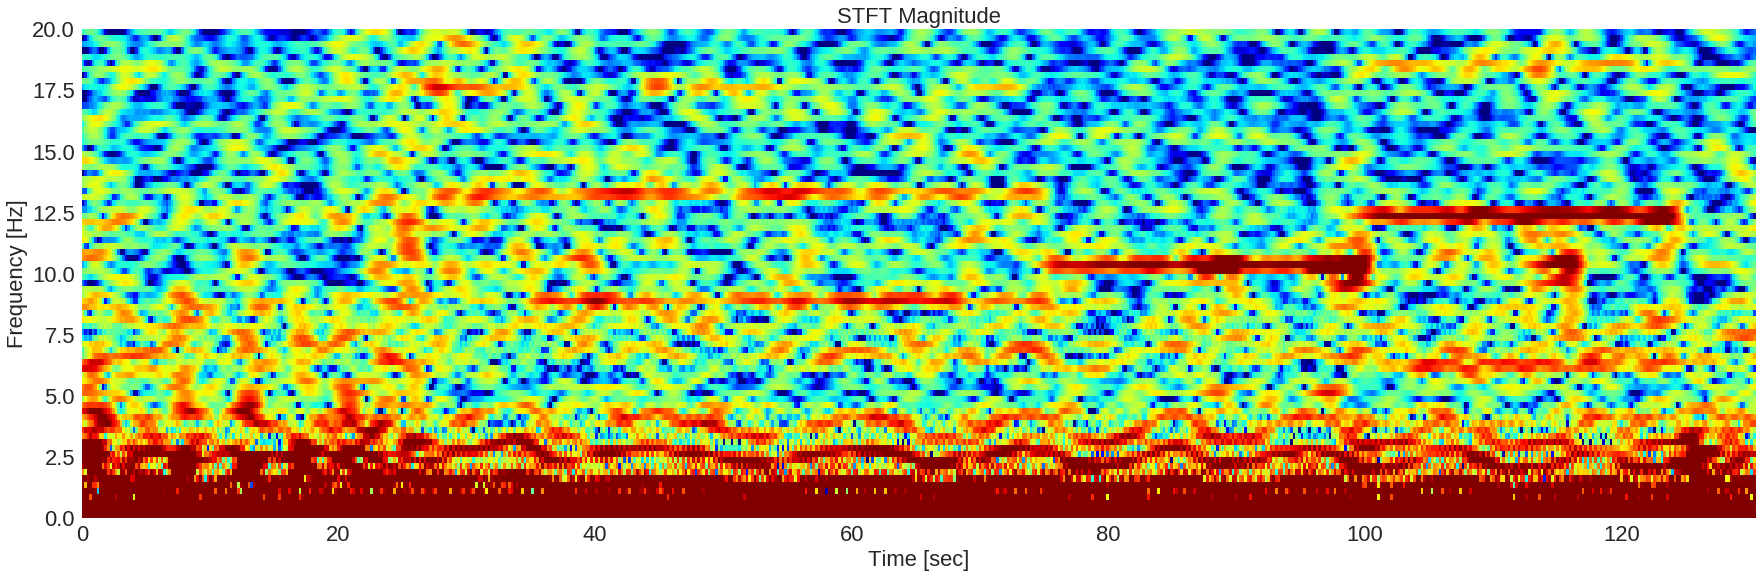

In [24]:
plt.figure(figsize=(30,9))
plt.pcolormesh(time_stamps, freqs, 10*np.log10(result)[:,:time_steps], cmap=plt.get_cmap('jet'))
plt.title('STFT Magnitude', fontsize=22)
plt.ylabel('Frequency [Hz]', fontsize=22)
plt.xlabel('Time [sec]', fontsize=22)
plt.clim(-10, 5)
plt.ylim(0,20)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.show()

In [25]:
freq_dict = {9: {"start_time":25, "freq":8.75},
             10: {"start_time":75, "freq":10.25},
             12: {"start_time":100, "freq":12.25}}

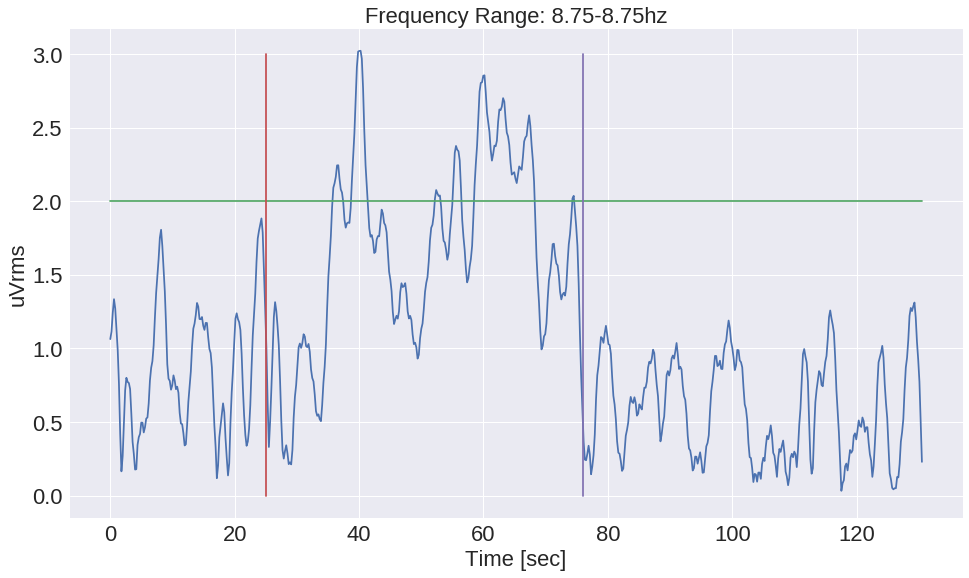

In [26]:
start_time = freq_dict[9]["start_time"]
end_time = start_time+51
min_freq = freq_dict[9]["freq"]
max_freq = freq_dict[9]["freq"]
alpha_9 = freq_filter(time_stamps, freqs, result[:,:time_steps], \
                      min_freq=min_freq, max_freq=max_freq, threshold=2, \
                      vertical_plots=(start_time, end_time),height=4)

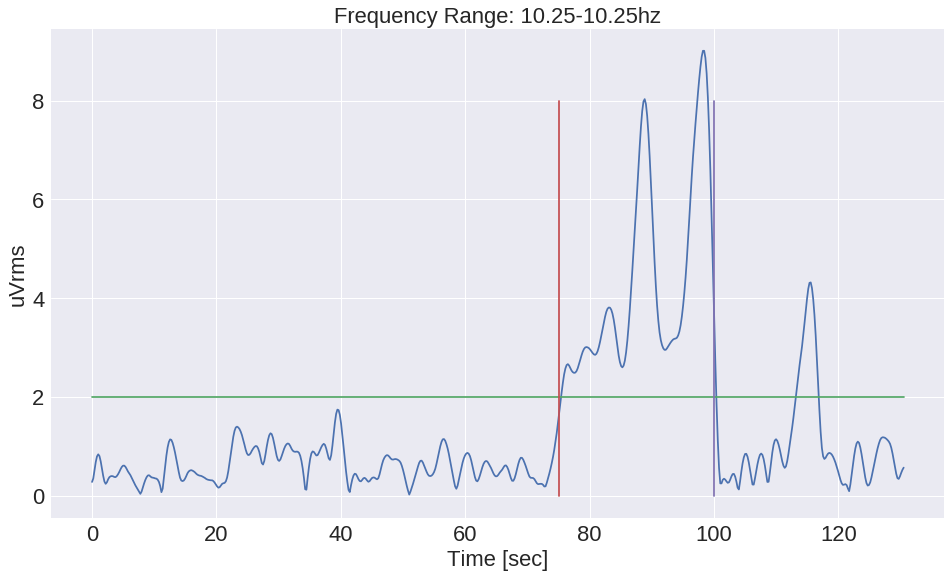

In [27]:
start_time = freq_dict[10]["start_time"]
end_time = start_time+25
min_freq = freq_dict[10]["freq"]
max_freq = freq_dict[10]["freq"]
alpha_10 = freq_filter(time_stamps, freqs, result[:,:time_steps], \
                       min_freq=min_freq, max_freq=max_freq, threshold=2,\
                       vertical_plots=(start_time,end_time), height=9)

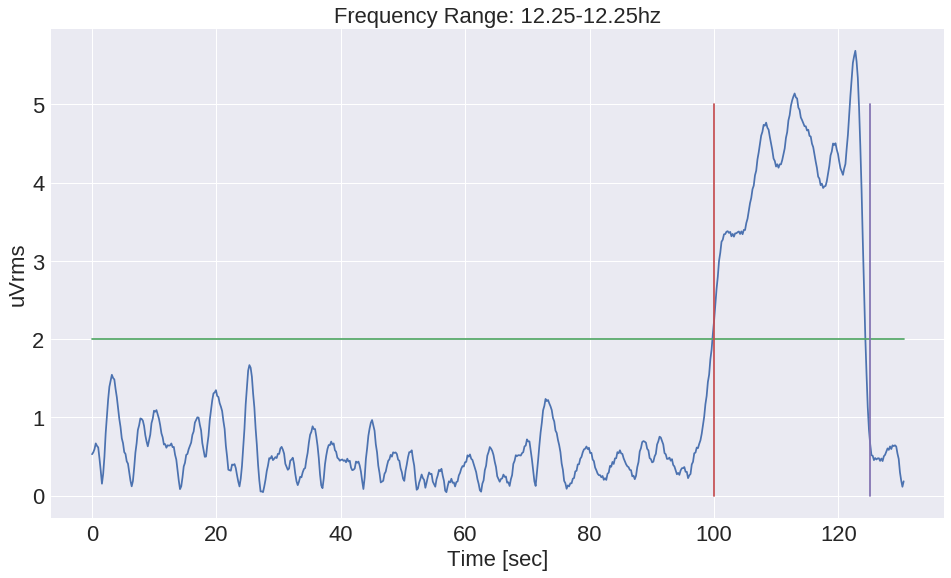

In [28]:
start_time = freq_dict[12]["start_time"]
end_time = start_time+25
min_freq = freq_dict[12]["freq"]
max_freq = freq_dict[12]["freq"]
alpha_12 = freq_filter(time_stamps, freqs, result[:,:time_steps], \
                       min_freq=min_freq, max_freq=max_freq, threshold=2, \
                       vertical_plots=(start_time,end_time), height=6)

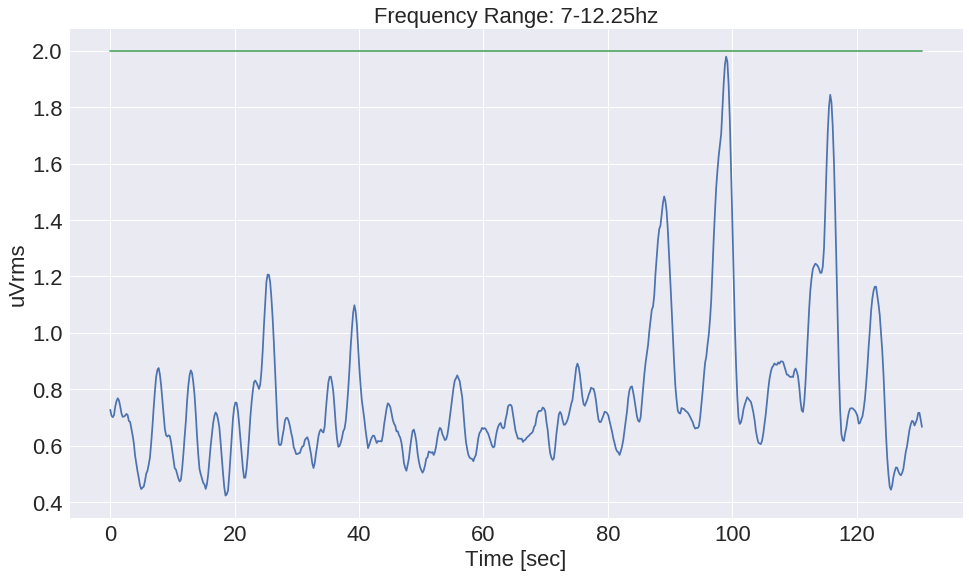

In [29]:
alpha_rando = freq_filter(time_stamps, freqs, result[:,:time_steps], min_freq=7, max_freq=12.25, threshold=2)

In [30]:
def rough_precision_recall(time_stamps, readings, hz, freq_dict, threshold=2, duration=25):
    """Evaluate the rough performance given the threshold used"""
    # each time step is ~0.2 seconds long
    # with 20 seconds of recording we should see ~1/.2 * 20 True results
    time_step = time_stamps[1]
    ground_truth_count = 1/time_step * duration
    start_index = int((1/time_step)*freq_dict[hz]["start_time"])
    end_index = int(start_index + ground_truth_count)
    ground_truth_readings = np.array([False]*len(time_stamps))
    ground_truth_readings[start_index:end_index] = True
    
    detections = []
    for reading in readings[:len(time_stamps)]:
        detections.append(reading > threshold)
    detections = np.array(detections)   
    
    #return ground_truth_readings, detections
    print(classification_report(ground_truth_readings, detections))

In [31]:
rough_precision_recall(time_stamps, alpha_9, 9, freq_dict,duration=50)

             precision    recall  f1-score   support

      False       0.71      1.00      0.83       406
       True       1.00      0.34      0.50       250

avg / total       0.82      0.75      0.71       656



In [32]:
rough_precision_recall(time_stamps, alpha_10, 10, freq_dict)

             precision    recall  f1-score   support

      False       0.99      0.96      0.98       531
       True       0.85      0.98      0.91       125

avg / total       0.97      0.96      0.96       656



In [33]:
rough_precision_recall(time_stamps, alpha_12, 12, freq_dict)

             precision    recall  f1-score   support

      False       1.00      1.00      1.00       531
       True       1.00      0.99      1.00       125

avg / total       1.00      1.00      1.00       656

